In [1]:
import pandas as pd
from biom import Table
from gemelli.preprocessing import rclr_transformation
from gemelli.rpca import rpca
from skbio.stats.composition import clr
from scipy.spatial.distance import cdist
from skbio.stats import subsample_counts


# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

### import the data

Data was obtained from here: https://github.com/riffomonas/distances

In [39]:
table_df = pd.read_csv('data/mice.shared', sep='\t', index_col=1).drop(['label','numOtus'], axis=1)
table_df = table_df[table_df.sum(1) > 1800].T
table_df = table_df[table_df.sum(1) > 10]
bt = Table(table_df.values, table_df.index, table_df.columns)
bt


362 x 348 <class 'biom.table.Table'> with 51547 nonzero entries (40% dense)

### Rarefaction with Bray-Curtis

In [40]:
import qiime2 as q2
from qiime2.plugins.feature_table.methods import rarefy
from qiime2.plugins.diversity.actions import beta
from skbio import DistanceMatrix



In [41]:
table = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
bt_rare = rarefy(table, 1806).rarefied_table.view(Table) # value used in the video
bt_rare


362 x 348 <class 'biom.table.Table'> with 36685 nonzero entries (29% dense)

In [42]:
bc_dist = beta(table, 'braycurtis').distance_matrix.view(DistanceMatrix).to_data_frame()
bc_dist.head(5)


,F3D0,F3D1,F3D11,F3D125,F3D13,F3D141,F3D142,F3D143,F3D144,F3D145,...,M6D3,M6D364,M6D4,M6D45,M6D5,M6D6,M6D65,M6D7,M6D8,M6D9
F3D0,0.000000,0.384319,0.613100,0.387684,0.590608,0.336879,0.493598,0.509648,0.389335,0.339941,...,0.477765,0.668091,0.659984,0.411424,0.561248,0.541250,0.586062,0.763930,0.415161,0.522300
F3D1,0.384319,0.000000,0.688801,0.531044,0.706536,0.476795,0.507287,0.530469,0.524752,0.580413,...,0.554643,0.760538,0.786063,0.577316,0.655721,0.611318,0.713050,0.849807,0.526934,0.634478
F3D11,0.613100,0.688801,0.000000,0.472463,0.250456,0.600066,0.736280,0.758044,0.662012,0.511594,...,0.512199,0.626286,0.376000,0.558816,0.387722,0.510208,0.364876,0.480049,0.603745,0.521216
F3D125,0.387684,0.531044,0.472463,0.000000,0.451758,0.407458,0.634534,0.629082,0.509163,0.326779,...,0.455785,0.535490,0.548529,0.329474,0.423905,0.490944,0.426868,0.654723,0.438761,0.491599
F3D13,0.590608,0.706536,0.250456,0.451758,0.000000,0.565020,0.711314,0.722163,0.621762,0.474343,...,0.450775,0.611421,0.403894,0.540795,0.351378,0.464714,0.386262,0.494043,0.569420,0.463926


In [43]:
bc_dists_compare = bc_dist.stack().reset_index()
bc_dists_compare.columns = ['s1','s2','dist']
total_counts = table_df.sum(0)
bc_dists_compare['diffs'] = [abs(total_counts[x] - total_counts[y])
                             for x, y in zip(bc_dists_compare.s1, 
                                             bc_dists_compare.s2)]
bc_dists_compare.head(5)



,s1,s2,dist,diffs
0,F3D0,F3D0,0.000000,0.0
1,F3D0,F3D1,0.384319,1533.0
2,F3D0,F3D11,0.613100,7257.0
3,F3D0,F3D125,0.387684,3655.0
4,F3D0,F3D13,0.590608,7196.0


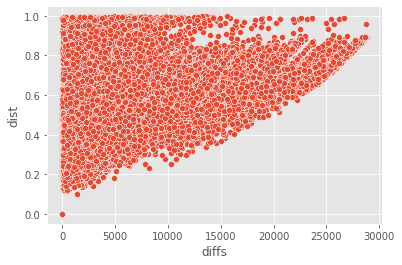

In [44]:
# plot results
sns.scatterplot(x='diffs', y='dist', data=bc_dists_compare)
plt.show()


### Analysis with the robust CLR + RPCA

In [45]:
# Note: the missing data is saved as NaNs _not_ zeros
rclr_transformation(bt).matrix_data.toarray()

array([[ 2.47291095,  1.18247055,  3.97677052, ...,  4.76842811,
         1.72276119,  2.00799237],
       [ 0.98607536,  1.61610653,  3.45320587, ...,  3.8498145 ,
         2.92469109,  3.46951016],
       [ 1.33889673, -0.42696737,  2.0754222 , ...,  3.98552375,
         1.08903743,  1.27228558],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ..., -1.99082716,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [46]:
# use RPCA (treat NaNs as missing)
dists_compare = rpca(bt)[1].to_data_frame().stack().reset_index()
dists_compare.columns = ['s1','s2','dist']
total_counts = table_df.sum(0)
dists_compare['diffs'] = [abs(total_counts[x] - total_counts[y])
                          for x, y in zip(dists_compare.s1, dists_compare.s2)]
dists_compare.head(5)


,s1,s2,dist,diffs
0,F3D0,F3D0,0.000000,0.0
1,F3D0,F3D1,1.163922,1533.0
2,F3D0,F3D11,1.774224,7257.0
3,F3D0,F3D125,0.978653,3655.0
4,F3D0,F3D13,2.176177,7196.0


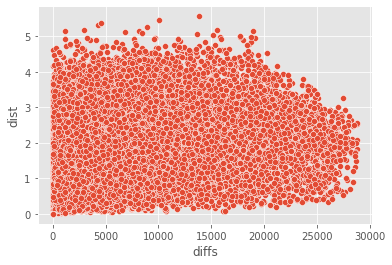

In [47]:
# plot results
sns.scatterplot(x='diffs', y='dist', data=dists_compare)
plt.show()
